# KBG Syndrome

[KBG syndrome (KBGS)](https://omim.org/entry/148050) is caused by heterozygous mutation in the ANKRD11 gene. In this notebook, we have used
[pyphetools](https://github.com/monarch-initiative/pyphetools) to parse the clinical data included in the supplemental files of
[Martinez-Cayuelas E, et al. Clinical description, molecular delineation and genotype-phenotype correlation in 340 patients with KBG syndrome: addition of 67 new patients](https://pubmed.ncbi.nlm.nih.gov/36446582).

The authors identified a significantly higher frequency of patients with a triangular face in carriers of sequence variants compared to CNVs. Other associations found were short stature and variants in exon 9, a lower incidence of ID/ADHD/ASD in carriers of the c.1903_1907del variant and the size of the deletion, in CNV carriers, with the presence of macrodontia and hand anomalies.

In [1]:
import genophenocorr
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2023-10-09')
print(f'Loaded HPO v{hpo.version}')
print(f"Using genophenocorr version {genophenocorr.__version__}")

Loaded HPO v2023-10-09
Using genophenocorr version 0.1.1dev


## Settings
Specify the transcript to be used to encode the variants (the phenopackets contain VCF representations of small variants).

### Pick transcript

We choose the [MANE Select](https://www.ncbi.nlm.nih.gov/nuccore/NM_013275.6) transcript for *ANKRD11*.

In [2]:
tx_id = 'NM_013275.6'

## Load Phenopackets

We will load phenopacket JSON files located in `phenopackets` folder that is next to the notebook.

In [3]:
from genophenocorr.preprocessing import configure_caching_cohort_creator, load_phenopacket_folder

fpath_phenopackets = 'phenopackets'
cohort_creator = configure_caching_cohort_creator(hpo, timeout=20)
cohort = load_phenopacket_folder(fpath_phenopackets, cohort_creator)



Patients Created: 100%|██████████| 337/337 [00:01<00:00, 294.05it/s]
Validated under none policy
Showing errors and warnings
337 phenopacket(s) found at `phenopackets`
  patient #4
    variants
     warnings:
     ·Expected a VCF record, a VRS CNV, or an expression with `hgvs.c` but had an error retrieving any from patient Novara, 2017_P4[PMID_36446582_Novara_2017_P4]. Remove variant from testing
     ·Patient PMID_36446582_Novara_2017_P4 has no variants to work with
  patient #13
    variants
     warnings:
     ·Expected a VCF record, a VRS CNV, or an expression with `hgvs.c` but had an error retrieving any from patient Ockeloen2015_P20[PMID_36446582_Ockeloen2015_P20]. Remove variant from testing
     ·Patient PMID_36446582_Ockeloen2015_P20 has no variants to work with
  patient #17
    variants
     warnings:
     ·Expected a VCF record, a VRS CNV, or an expression with `hgvs.c` but had an error retrieving any from patient Willemsen2010_P1[PMID_36446582_Willemsen2010_P1]. Remove var

## Summarize the cohort

In [4]:
from IPython.display import display, HTML
from genophenocorr.view import CohortViewable

cv = CohortViewable(hpo=hpo)
html = cv.process(cohort=cohort, transcript_id=tx_id)

display(HTML(html))

HPO Term,ID,Annotation Count
Macrodontia,HP:0001572,211
Intellectual disability,HP:0001249,194
Abnormality of the hand,HP:0001155,189
Global developmental delay,HP:0001263,176
Delayed speech and language development,HP:0000750,160
Short stature,HP:0004322,150
Thick eyebrow,HP:0000574,126
Long philtrum,HP:0000343,121
Bulbous nose,HP:0000414,89
Triangular face,HP:0000325,83


In [5]:
from genophenocorr.preprocessing import UniprotProteinMetadataService
from genophenocorr.model.genome import GRCh38
from genophenocorr.preprocessing import VVTranscriptCoordinateService
pms = UniprotProteinMetadataService()
protein_meta = pms.annotate('NP_037407.4')
txc_service = VVTranscriptCoordinateService(genome_build=GRCh38)
tx_coordinates = txc_service.fetch(tx_id)

In [6]:
from genophenocorr.view import ProteinVisualizable, ProteinVisualizer, ProteinViewable

pvis = ProteinVisualizable(tx_coordinates=tx_coordinates, protein_meta=protein_meta, cohort=cohort)

In [7]:
viewer = ProteinViewable()
html_prot = viewer.process(cohort, pvis)
display(HTML(html_prot))

Feature Name,Feature Type,Feature Coordinates,Variants in Feature
Disordered,region,1 - 90,1
Disordered,region,128 - 169,1
ANK 1,repeat,167 - 196,3
ANK 2,repeat,200 - 229,0
ANK 3,repeat,233 - 262,0
ANK 4,repeat,266 - 292,3
Disordered,region,289 - 380,2
Disordered,region,398 - 647,60
Disordered,region,723 - 783,12
Disordered,region,881 - 1043,12


<Axes: title={'center': 'Ankyrin repeat domain-containing protein 11\ntranscript: NM_013275.6, protein: NP_037407.4'}>

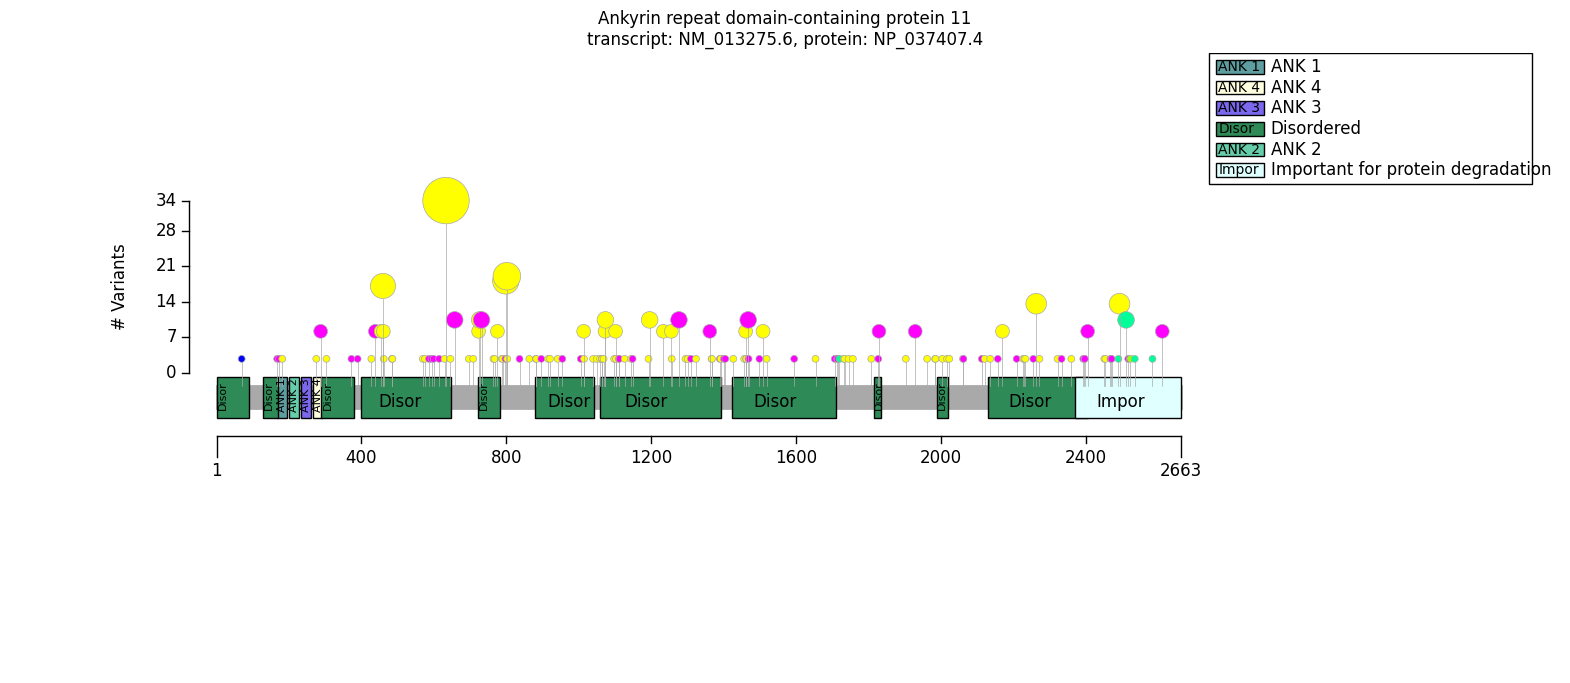

In [8]:
drawer = ProteinVisualizer()
drawer.draw_fig(pvis=pvis)

## Configure the analysis

In [9]:
from genophenocorr.analysis import configure_cohort_analysis, CohortAnalysisConfiguration
from genophenocorr.analysis.predicate import PatientCategories
from genophenocorr.model.genome import Region

analysis_config = CohortAnalysisConfiguration()
analysis_config.missing_implies_excluded = False

analysis = configure_cohort_analysis(cohort, hpo, config=analysis_config)

Test for presence of genotype-phenotype correlations between frameshift variants vs. others.

In [10]:
from genophenocorr.model import VariantEffect
from genophenocorr.analysis.predicate.genotype import VariantPredicates

frameshift_predicate = VariantPredicates.variant_effect(VariantEffect.FRAMESHIFT_VARIANT, tx_id=tx_id)
frameshift = analysis.compare_hpo_vs_genotype(frameshift_predicate)
frameshift.summarize(hpo, PatientCategories.YES)

FRAMESHIFT_VARIANT on NM_013275.6                     Yes             No  \
                                                    Count Percent  Count   
Abnormality of the hand [HP:0001155]               95/144     66%  60/71   
EEG abnormality [HP:0002353]                         7/33     21%   9/16   
Feeding difficulties [HP:0011968]                   33/89     37%  26/45   
Low anterior hairline [HP:0000294]                  40/58     69%  15/30   
Intellectual disability [HP:0001249]               99/119     83%  59/64   
...                                                   ...     ...    ...   
Abnormality of the digestive system [HP:0025031]    35/35    100%  29/29   
Abnormal cardiac atrium morphology [HP:0005120]       3/3    100%    4/4   
Abnormal dental morphology [HP:0006482]           115/115    100%  55/55   
Phenotypic abnormality [HP:0000118]               174/174    100%  82/82   
Abnormal eye physiology [HP:0012373]                12/12    100%    4/4   

FRAMESHIFT_VARIANT on NM_013275.6                                   \
                                                 Percent   p value   
Abnormality of the hand [HP:0001155]                 85%  0.005661   
EEG abnormality [HP:0002353]                         56%  0.022884   
Feeding difficulties [HP:0011968]                    58%  0.027584   
Low anterior hairline [HP:0000294]                   50%  0.105274   
Intellectual disability [HP:0001249]                 92%  0.115195   
...                                                  ...       ...   
Abnormality of the digestive system [HP:0025031]    100%  1.000000   
Abnormal cardiac atrium morphology [HP:0005120]     100%  1.000000   
Abnormal dental morphology [HP:0006482]             100%  1.000000   
Phenotypic abnormality [HP:0000118]                 100%  1.000000   
Abnormal eye physiology [HP:0012373]                100%  1.000000   

FRAMESHIFT_VARIANT on NM_013275.6                                   
                                                 Corrected p value  
Abnormality of the hand [HP:0001155]                           1.0  
EEG abnormality [HP:0002353]                                   1.0  
Feeding difficulties [HP:0011968]                              1.0  
Low anterior hairline [HP:0000294]                             1.0  
Intellectual disability [HP:0001249]                           1.0  
...                                                            ...  
Abnormality of the digestive system [HP:0025031]               1.0  
Abnormal cardiac atrium morphology [HP:0005120]                1.0  
Abnormal dental morphology [HP:0006482]                        1.0  
Phenotypic abnormality [HP:0000118]                            1.0  
Abnormal eye physiology [HP:0012373]                           1.0  

[189 rows x 6 columns]

Run the analysis with the HPO filter to reduce the number of tested phenotypes.

In [11]:
from genophenocorr.analysis import configure_cohort_analysis, CohortAnalysisConfiguration
from genophenocorr.analysis.predicate import PatientCategories

analysis_config = CohortAnalysisConfiguration()
analysis_config.missing_implies_excluded = False
analysis_config.min_perc_patients_w_hpo = 0.2
analysis_config.heuristic_strategy()
analysis = configure_cohort_analysis(cohort, hpo, config=analysis_config)

In [12]:
frameshift = analysis.compare_hpo_vs_genotype(frameshift_predicate)
frameshift.summarize(hpo, PatientCategories.YES)

FRAMESHIFT_VARIANT on NM_013275.6                       Yes             No  \
                                                      Count Percent  Count   
Abnormality of the hand [HP:0001155]                 95/144     66%  60/71   
EEG abnormality [HP:0002353]                           7/33     21%   9/16   
Feeding difficulties [HP:0011968]                     33/89     37%  26/45   
Low anterior hairline [HP:0000294]                    40/58     69%  15/30   
Intellectual disability [HP:0001249]                 99/119     83%  59/64   
Delayed skeletal maturation [HP:0002750]              37/86     43%  17/28   
Intrauterine growth retardation [HP:0001511]           6/39     15%   7/23   
Bulbous nose [HP:0000414]                             45/71     63%  29/39   
Hypertelorism [HP:0000316]                            34/63     54%  25/38   
Microretrognathia [HP:0000308]                        13/36     36%   3/16   
Sleep abnormality [HP:0002360]                        15/40     38%   4/17   
Short stature [HP:0004322]                           73/126     58%  42/65   
Delayed speech and language development [HP:000...    77/92     84%  44/49   
Exaggerated cupid's bow [HP:0002263]                  11/35     31%   2/12   
Mandibular prognathia [HP:0000303]                     8/33     24%   5/14   
Cryptorchidism [HP:0000028]                           20/51     39%  15/31   
Thick eyebrow [HP:0000574]                            68/82     83%  38/49   
Triangular face [HP:0000325]                          45/63     71%  23/36   
Microcephaly [HP:0000252]                             18/74     24%  12/39   
Motor delay [HP:0001270]                              36/52     69%  19/25   
Focal-onset seizure [HP:0007359]                        4/8     50%    4/6   
Low-set ears [HP:0000369]                             16/30     53%   5/11   
Recurrent otitis media [HP:0000403]                   17/36     47%   7/17   
Protruding ear [HP:0000411]                           32/44     73%  16/23   
Autistic behavior [HP:0000729]                        26/48     54%  14/24   
Macrodontia [HP:0001572]                            115/145     79%  55/68   
Generalized non-motor (absence) seizure [HP:000...      1/4     25%    2/4   
Hypotonia [HP:0001252]                                14/35     40%   7/18   
Global developmental delay [HP:0001263]               86/91     95%  46/48   
Febrile seizure (within the age range of 3 mont...      3/5     60%    2/3   
Long philtrum [HP:0000343]                            66/82     80%  38/48   
Anteverted nares [HP:0000463]                         41/58     71%  22/30   
Prominent nose [HP:0000448]                           12/28     43%   5/13   
Strabismus [HP:0000486]                               12/51     24%   4/19   
Attention deficit hyperactivity disorder [HP:00...    34/44     77%  19/24   
Generalized-onset seizure [HP:0002197]                  8/9     89%    4/5   

FRAMESHIFT_VARIANT on NM_013275.6                                     \
                                                   Percent   p value   
Abnormality of the hand [HP:0001155]                   85%  0.005661   
EEG abnormality [HP:0002353]                           56%  0.022884   
Feeding difficulties [HP:0011968]                      58%  0.027584   
Low anterior hairline [HP:0000294]                     50%  0.105274   
Intellectual disability [HP:0001249]                   92%  0.115195   
Delayed skeletal maturation [HP:0002750]               61%  0.128802   
Intrauterine growth retardation [HP:0001511]           30%  0.202568   
Bulbous nose [HP:0000414]                              74%  0.291265   
Hypertelorism [HP:0000316]                             66%  0.299330   
Microretrognathia [HP:0000308]                         19%  0.330525   
Sleep abnormality [HP:0002360]                         24%  0.370187   
Short stature [HP:0004322]                             65%  0.436104   
Delayed speech and language

In [13]:
analysis_config = CohortAnalysisConfiguration()
analysis_config.missing_implies_excluded = False
analysis_config.min_perc_patients_w_hpo = 0.2
terms_to_test = {"HP:0001249", "HP:0001263"} # Intellectual disability HP:0001249 and Global developmental delay HP:0001263 
analysis_config.specify_terms_strategy(specified_term_set=terms_to_test)
analysis = configure_cohort_analysis(cohort, hpo, config=analysis_config)


In [14]:
frameshift = analysis.compare_hpo_vs_genotype(frameshift_predicate)
frameshift.summarize(hpo, PatientCategories.YES)

FRAMESHIFT_VARIANT on NM_013275.6           Yes             No          \
                                          Count Percent  Count Percent   
Intellectual disability [HP:0001249]     99/119     83%  59/64     92%   
Global developmental delay [HP:0001263]   86/91     95%  46/48     96%   

FRAMESHIFT_VARIANT on NM_013275.6                                    
                                          p value Corrected p value  
Intellectual disability [HP:0001249]     0.115195          0.230389  
Global developmental delay [HP:0001263]  1.000000          1.000000

In [15]:
from genophenocorr.view import StatsViewer

sv = StatsViewer()

stats_report = sv.process(frameshift.mtc_filter_report)

display(HTML(stats_report))

Reason,Count
Skipping non-specified term,187


Test for presence of genotype-phenotype correlations between subjects with >=1 allele of a variant vs. the other subjects:


In [16]:
variant_key_predicate = VariantPredicates.variant_key('16_89284634_89284639_GTGTTT_G')
var_single = analysis.compare_hpo_vs_genotype(variant_key_predicate)
var_single.summarize(hpo, PatientCategories.YES)

variant has ID of 16_89284634_89284639_GTGTTT_G    Yes               No  \
                                                 Count Percent    Count   
Intellectual disability [HP:0001249]             14/19     74%  144/164   
Global developmental delay [HP:0001263]          15/16     94%  117/123   

variant has ID of 16_89284634_89284639_GTGTTT_G                    \
                                                Percent   p value   
Intellectual disability [HP:0001249]                88%  0.147465   
Global developmental delay [HP:0001263]             95%  0.583703   

variant has ID of 16_89284634_89284639_GTGTTT_G                    
                                                Corrected p value  
Intellectual disability [HP:0001249]                     0.294929  
Global developmental delay [HP:0001263]                  1.000000

Or between subjects with one variant vs. the other variant.

In [17]:
exon_predicate = VariantPredicates.exon(9, tx_id)
var_double = analysis.compare_hpo_vs_genotype(exon_predicate)
var_double.summarize(hpo, PatientCategories.YES)

variant affects exon 9 on NM_013275.6        Yes             No          \
                                           Count Percent  Count Percent   
Intellectual disability [HP:0001249]     135/159     85%  23/24     96%   
Global developmental delay [HP:0001263]  120/126     95%  12/13     92%   

variant affects exon 9 on NM_013275.6                                
                                          p value Corrected p value  
Intellectual disability [HP:0001249]     0.207310           0.41462  
Global developmental delay [HP:0001263]  0.505131           1.00000

In [18]:
from genophenocorr.analysis import configure_default_protein_metadata_service
from genophenocorr.analysis.predicate.genotype import ProteinPredicates

protein_metadata_service = configure_default_protein_metadata_service()
pp = ProteinPredicates(protein_metadata_service=protein_metadata_service)
predicate = pp.protein_feature('Important for protein degradation', tx_id)

prot_test = analysis.compare_hpo_vs_genotype(predicate)
prot_test.summarize(hpo,PatientCategories.YES)

Variant that affects Important for protein degradation feature on the protein encoded by transcript NM_013275.6    Yes  \
                                                                                                                 Count   
Intellectual disability [HP:0001249]                                                                             20/22   
Global developmental delay [HP:0001263]                                                                          11/11   

Variant that affects Important for protein degradation feature on the protein encoded by transcript NM_013275.6          \
                                                                                                                Percent   
Intellectual disability [HP:0001249]                                                                                91%   
Global developmental delay [HP:0001263]                                                                            100%   

Variant that affects Important for protein degradation feature on the protein encoded by transcript NM_013275.6       No  \
                                                                                                                   Count   
Intellectual disability [HP:0001249]                                                                             138/161   
Global developmental delay [HP:0001263]                                                                          121/128   

Variant that affects Important for protein degradation feature on the protein encoded by transcript NM_013275.6          \
                                                                                                                Percent   
Intellectual disability [HP:0001249]                                                                                86%   
Global developmental delay [HP:0001263]                                                                             95%   

Variant that affects Important for protein degradation feature on the protein encoded by transcript NM_013275.6            \
                                                                                                                  p value   
Intellectual disability [HP:0001249]                                                                             0.743276   
Global developmental delay [HP:0001263]                                                                          1.000000   

Variant that affects Important for protein degradation feature on the protein encoded by transcript NM_013275.6                    
                                                                                                                Corrected p value  
Intellectual disability [HP:0001249]                                                                                          1.0  
Global developmental delay [HP:0001263]                                                                                       1.0

In [19]:
protein_region_predicate = VariantPredicates.region(Region(400, 800), tx_id)
prot_test = analysis.compare_hpo_vs_genotype(protein_region_predicate)
prot_test.summarize(hpo,PatientCategories.YES)

variant affects aminoacid(s) between 400 and 800 on protein encoded by transcript NM_013275.6    Yes  \
                                                                                               Count   
Global developmental delay [HP:0001263]                                                        46/49   
Intellectual disability [HP:0001249]                                                           51/59   

variant affects aminoacid(s) between 400 and 800 on protein encoded by transcript NM_013275.6          \
                                                                                              Percent   
Global developmental delay [HP:0001263]                                                           94%   
Intellectual disability [HP:0001249]                                                              86%   

variant affects aminoacid(s) between 400 and 800 on protein encoded by transcript NM_013275.6       No  \
                                                                                                 Count   
Global developmental delay [HP:0001263]                                                          86/90   
Intellectual disability [HP:0001249]                                                           107/124   

variant affects aminoacid(s) between 400 and 800 on protein encoded by transcript NM_013275.6          \
                                                                                              Percent   
Global developmental delay [HP:0001263]                                                           96%   
Intellectual disability [HP:0001249]                                                              86%   

variant affects aminoacid(s) between 400 and 800 on protein encoded by transcript NM_013275.6            \
                                                                                                p value   
Global developmental delay [HP:0001263]                                                        0.697067   
Intellectual disability [HP:0001249]                                                           1.000000   

variant affects aminoacid(s) between 400 and 800 on protein encoded by transcript NM_013275.6                    
                                                                                              Corrected p value  
Global developmental delay [HP:0001263]                                                                     1.0  
Intellectual disability [HP:0001249]                                                                        1.0

TODO - finalize!